<a href="https://colab.research.google.com/github/pallavikhadse/Stock-prediction-MLP-with-Keras/blob/master/Stock_price_prediction_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

## Getting the tickers (symbols) of few companies in S&P 500 from wikipedia website and saving to a file

In [2]:
import bs4 as bs    # bs4 is a Python library called BeautifulSoup4, used for pulling data out of HTML & XML files.
import requests     # requests is a Python module, used for sending HTTP request. The HTTP request returns a Response object with all the data like (content, encoding, status, etc)
import pickle       # pickle is a Python module, used for serializing & de-serializing a object structure.

In [3]:
def fetch_tickers_wikipedia():
    response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(response.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})       # Searching table in wikipedia with class-wikitable sortable
    
    tickers = []
    
    for row in table.findAll('tr')[20:50]:          # tr is row of the table and from row 1 is considered, row 0 is Header which is avoided
        ticker = row.findAll('td')[0].get_text(strip = True).replace('.', '-')       # td is column of the table and 0 is the first column
        tickers.append(ticker)
        fileName = "tickers_snp500.pickle"
        fileObject = open(fileName, 'wb')       # wb for writing into file
    with fileObject as f:
        pickle.dump(tickers, f)                 # writing into tickers_snp500 file
    return tickers

fetch_tickers_wikipedia()

['ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM']

## fetching historical stock of above fetched tickers of s&p 500 from Yahoo finance

In [4]:
!pip install yfinance

In [5]:
import os
import datetime as dt
import yfinance as yf
import pandas as pd


def fetch_snp500_yahoo():
    with open("tickers_snp500.pickle", "rb") as f:    # Command Open "tickers_snp500.pickle" to read
        tickers = pickle.load(f)
        
    if not os.path.exists('snp500_folder'):     # If folder snp500_folder does not exit, then make a new folder
        os.makedirs('snp500_folder')
        
    for ticker in tickers:
        print(ticker)        
        stockData = 'snp500_folder/{}.csv'.format(ticker)         # convert above data to csv and save in folder snp500_folder
        f = open(stockData, 'w')                                  # Command Open to write
        ticker = yf.Ticker(ticker)
        df = ticker.history(start = "2019-8-1", end = "2020-8-31")     # Read ticker stock from yahoo with the given dates
        f.write(df.to_csv())
        f.close()
        
        
fetch_snp500_yahoo()  

ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
ANTM
AON
AOS
APA
AAPL
AMAT
APTV
ADM


# Reading data of our targeted stock - Google

In [6]:
googl_df = pd.read_csv('/content/snp500_folder/GOOGL.csv', parse_dates=['Date'])
googl_df.tail

<bound method NDFrame.tail of           Date         Open         High  ...   Volume  Dividends  Stock Splits
0   2019-08-01  1217.630005  1236.300049  ...  1771300          0             0
1   2019-08-02  1203.000000  1209.500000  ...  1745500          0             0
2   2019-08-05  1172.969971  1176.880005  ...  2392000          0             0
3   2019-08-06  1165.520020  1181.400024  ...  1800700          0             0
4   2019-08-07  1157.800049  1179.869995  ...  1534300          0             0
..         ...          ...          ...  ...      ...        ...           ...
268 2020-08-24  1592.469971  1608.780029  ...  1281900          0             0
269 2020-08-25  1580.099976  1608.880005  ...  1257500          0             0
270 2020-08-26  1606.300049  1652.790039  ...  2609400          0             0
271 2020-08-27  1646.609985  1647.989990  ...  1567500          0             0
272 2020-08-28  1629.469971  1641.349976  ...  1120900          0             0

[273 rows

In [7]:
googl_df = googl_df.drop(columns = ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])        # Dropping two columns which are not required

In [8]:
googl_df = googl_df.set_index('Date')           # Making Date column to index
googl_df = googl_df.rename(columns = {'Open': 'Open_GOOGL'})
googl_df

,Open_GOOGL
Date,
2019-08-01,1217.630005
2019-08-02,1203.000000
2019-08-05,1172.969971
2019-08-06,1165.520020
2019-08-07,1157.800049
...,...
2020-08-24,1592.469971
2020-08-25,1580.099976
2020-08-26,1606.300049


## Combining column 'Open' of above companies from s&p500 


In [9]:
def combine_data():
    data_tickers = pd.DataFrame()
    with open("tickers_snp500.pickle", "rb") as f:
        tickers = pickle.load(f)
    
    for count, ticker in enumerate(tickers):
        if 'GOOGL' in ticker:                # If GOOGL is present in tickers pickle file list then continue
            continue
        if not os.path.exists('snp500_folder/{}.csv'.format(ticker)):     # If format(ticker) is not equal to format(GOOGL) then continue 
            continue                                                      # We continue because we want all tickers except GOOGL
        data_ticker = pd.read_csv('snp500_folder/{}.csv'.format(ticker))
        data_ticker = data_ticker.set_index('Date')
        data_ticker = data_ticker.drop(columns = ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
        #data_ticker = data_ticker.drop(columns=['High', 'Low', 'Volume'])
        #data_ticker = data_ticker.set_index('Date')                        # Read data of each ticker and change its index to column Date
        #data_ticker = data_ticker.rename(columns = {'Open': 'Open_'+ticker, 'Close': 'Close_'+ticker})
        data_ticker = data_ticker.rename(columns = {'Open': 'Open_'+ticker})
        if data_tickers.empty:
            data_tickers = data_ticker
        else:
            data_tickers = data_tickers.join(data_ticker, how = 'outer')                
        
    print(data_tickers)
       
    data_tickers.to_csv('Data_tickers.csv')
                                        
combine_data()                                   

             Open_ALLE   Open_LNT    Open_ALL  ...  Open_AMAT  Open_APTV   Open_ADM
Date                                           ...                                 
2019-07-31         NaN        NaN         NaN  ...        NaN        NaN        NaN
2019-08-01  101.741234  47.370795  104.419475  ...  48.395348  87.882773  38.810847
2019-08-02  100.404217  48.319169  101.500903  ...  46.985777  82.463906  38.669266
2019-08-05   98.290554  48.185050  100.540954  ...  45.223813  80.528609  36.819336
2019-08-06   98.438015  47.744394   98.795629  ...  45.439161  81.354991  36.026509
...                ...        ...         ...  ...        ...        ...        ...
2020-08-24   99.833674  53.455089   93.750107  ...  63.172572  84.550003  43.203493
2020-08-25  102.686064  54.233225   94.303963  ...  63.920351  86.029999  44.159847
2020-08-26  101.433797  53.504333   92.365468  ...  63.860531  85.309998  43.854206
2020-08-27  102.248768  53.652084   92.526837  ...  64.099821  85.849998  43

## Drop unwanted columns

In [10]:
Data_tickers = pd.read_csv('Data_tickers.csv', parse_dates=['Date'])
Data_tickers = Data_tickers.set_index('Date')
Data_tickers_final = Data_tickers.drop(columns = ['Open_MO', 'Open_ALLE', 'Open_GOOG', 'Open_LNT', 'Open_ALL', 'Open_AMCR', 'Open_AEE', 'Open_AAL', 'Open_AEP', 'Open_AXP', 'Open_AIG', 'Open_AMT', 'Open_AWK', 'Open_AMP', 'Open_ABC', 'Open_AME', 'Open_AMGN', 'Open_APH', 'Open_ADI', 'Open_ANSS', 'Open_ANTM', 'Open_AON', 'Open_AOS', 'Open_APA', 'Open_AMAT', 'Open_APTV', 'Open_ADM'])
Data_tickers_final

,Open_AMZN,Open_AAPL
Date,,
2019-07-31,NaN,NaN
2019-08-01,1871.719971,52.579799
2019-08-02,1845.069946,50.522337
2019-08-05,1770.219971,48.668894
2019-08-06,1792.229980,48.255917
...,...,...
2020-08-24,3310.149902,128.284145
2020-08-25,3294.989990,124.297002
2020-08-26,3351.110107,125.774736


## Concatenate Google with Amazon and Apple 

In [11]:
dataset_original = pd.concat([googl_df, Data_tickers_final], axis = 1, join = 'outer')
dataset_original

,Open_GOOGL,Open_AMZN,Open_AAPL
Date,,,
2019-07-31,NaN,NaN,NaN
2019-08-01,1217.630005,1871.719971,52.579799
2019-08-02,1203.000000,1845.069946,50.522337
2019-08-05,1172.969971,1770.219971,48.668894
2019-08-06,1165.520020,1792.229980,48.255917
...,...,...,...
2020-08-24,1592.469971,3310.149902,128.284145
2020-08-25,1580.099976,3294.989990,124.297002
2020-08-26,1606.300049,3351.110107,125.774736


In [12]:
dataset_original.describe

<bound method NDFrame.describe of              Open_GOOGL    Open_AMZN   Open_AAPL
Date                                            
2019-07-31          NaN          NaN         NaN
2019-08-01  1217.630005  1871.719971   52.579799
2019-08-02  1203.000000  1845.069946   50.522337
2019-08-05  1172.969971  1770.219971   48.668894
2019-08-06  1165.520020  1792.229980   48.255917
...                 ...          ...         ...
2020-08-24  1592.469971  3310.149902  128.284145
2020-08-25  1580.099976  3294.989990  124.297002
2020-08-26  1606.300049  3351.110107  125.774736
2020-08-27  1646.609985  3450.050049  126.734148
2020-08-28  1629.469971  3423.000000  125.607771

[274 rows x 3 columns]>

In [13]:
dataset_original = dataset_original.drop(pd.Timestamp('31-07-2019'))

In [14]:
dataset_original.shape

(273, 3)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter
import seaborn as sns

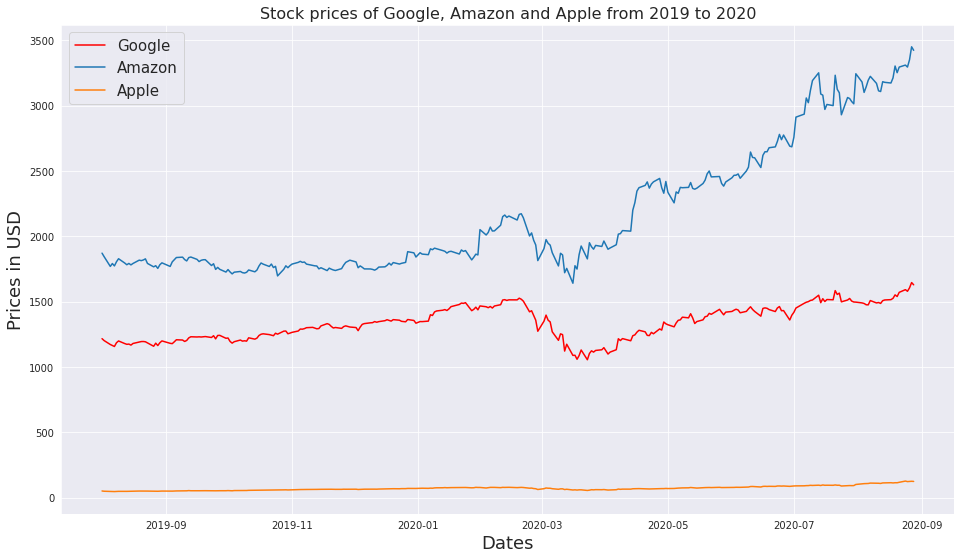

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(dataset_original['Open_GOOGL'], color = 'red', label = 'Google')
plt.plot(dataset_original['Open_AMZN'], label = 'Amazon')
plt.plot(dataset_original['Open_AAPL'], label = 'Apple')
plt.title("Stock prices of Google, Amazon and Apple from 2019 to 2020", fontsize = 16)
plt.xlabel('Dates', fontsize = 18)
plt.xticks(x = 'Date', rotation = 0)
#plt.margins(0.2)
plt.ylabel('Prices in USD', fontsize = 18)
plt.legend(fontsize=15)
plt.show()

## Split dataset into training and testing

In [17]:
  # Splitting dataset into 70%-30%

training_size = int(len(dataset_original)*0.7)                # int for rounded value / whole number
testing_size = len(dataset_original)-training_size

training_size, testing_size

(191, 82)

In [18]:
training_data = dataset_original.iloc[0:training_size, :].values
testing_data = dataset_original.iloc[training_size:len(dataset_original), :].values

In [19]:
training_data, testing_data

(array([[1217.63000488, 1871.7199707 ,   52.57979898],
        [1203.        , 1845.06994629,   50.52233653],
        [1172.9699707 , 1770.2199707 ,   48.66889375],
        [1165.52001953, 1792.22998047,   48.25591662],
        [1157.80004883, 1773.98999023,   48.03468882],
        [1186.43005371, 1806.        ,   49.21214152],
        [1199.98999023, 1828.94995117,   49.6705429 ],
        [1180.        , 1795.98999023,   49.25600415],
        [1174.34997559, 1783.        ,   49.60145397],
        [1176.06994629, 1793.01000977,   50.12949587],
        [1168.43005371, 1781.98999023,   50.20351824],
        [1180.79003906, 1792.89001465,   50.40585344],
        [1191.82995605, 1818.07995605,   51.97024497],
        [1195.34997559, 1814.5       ,   52.03440024],
        [1195.81994629, 1819.39001465,   52.55504113],
        [1193.80004883, 1828.        ,   52.60438861],
        [1185.17004395, 1793.0300293 ,   51.67660939],
        [1159.44995117, 1766.91003418,   50.79571889],
        [1

In [20]:
training_data.shape, testing_data.shape

((191, 3), (82, 3))

## Data preparation

In [21]:
#To normalise the data in (0, 1), MinMax scaler module is used
from sklearn.preprocessing import MinMaxScaler

In [22]:
sc = MinMaxScaler(feature_range = (0,1))
training_data_scaled = sc.fit_transform(training_data)
training_data_scaled

array([[0.34250159, 0.28715586, 0.13973846],
       [0.31142879, 0.25391355, 0.07648221],
       [0.24764774, 0.1605483 , 0.0194985 ],
       [0.23182472, 0.18800282, 0.0068016 ],
       [0.21542821, 0.1652509 , 0.        ],
       [0.27623573, 0.20517906, 0.03620054],
       [0.30503581, 0.23380603, 0.05029399],
       [0.26257888, 0.19269293, 0.03754909],
       [0.25057875, 0.17648967, 0.04816987],
       [0.25423181, 0.1889758 , 0.06440441],
       [0.23800537, 0.17522982, 0.06668021],
       [0.26425686, 0.18882612, 0.07290096],
       [0.28770464, 0.22024718, 0.12099785],
       [0.29518084, 0.21578166, 0.12297029],
       [0.29617901, 0.2218813 , 0.13897729],
       [0.29188893, 0.23262109, 0.14049447],
       [0.27355959, 0.18900077, 0.11197009],
       [0.21893245, 0.15641961, 0.08488729],
       [0.26895061, 0.1674213 , 0.10005968],
       [0.23044413, 0.14156345, 0.07153553],
       [0.27621447, 0.17648967, 0.10491493],
       [0.30580038, 0.19456397, 0.11750811],
       [0.

In [23]:
training_data_scaled.shape

(191, 3)

In [24]:
len(training_data_scaled)  

191

In [25]:
# Timesteps considered = 30 days.

X_train = []
y_train = []

for i in range(30, len(training_data_scaled)):
    X_train.append(training_data_scaled[i-30:i, 0:])
    y_train.append(training_data_scaled[i, 0])

X_train, y_train

([array([[0.34250159, 0.28715586, 0.13973846],
         [0.31142879, 0.25391355, 0.07648221],
         [0.24764774, 0.1605483 , 0.0194985 ],
         [0.23182472, 0.18800282, 0.0068016 ],
         [0.21542821, 0.1652509 , 0.        ],
         [0.27623573, 0.20517906, 0.03620054],
         [0.30503581, 0.23380603, 0.05029399],
         [0.26257888, 0.19269293, 0.03754909],
         [0.25057875, 0.17648967, 0.04816987],
         [0.25423181, 0.1889758 , 0.06440441],
         [0.23800537, 0.17522982, 0.06668021],
         [0.26425686, 0.18882612, 0.07290096],
         [0.28770464, 0.22024718, 0.12099785],
         [0.29518084, 0.21578166, 0.12297029],
         [0.29617901, 0.2218813 , 0.13897729],
         [0.29188893, 0.23262109, 0.14049447],
         [0.27355959, 0.18900077, 0.11197009],
         [0.21893245, 0.15641961, 0.08488729],
         [0.26895061, 0.1674213 , 0.10005968],
         [0.23044413, 0.14156345, 0.07153553],
         [0.27621447, 0.17648967, 0.10491493],
         [0.3

In [26]:
# Convert to numpy array

import numpy as np

In [27]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train, y_train

(array([[[0.34250159, 0.28715586, 0.13973846],
         [0.31142879, 0.25391355, 0.07648221],
         [0.24764774, 0.1605483 , 0.0194985 ],
         ...,
         [0.29675251, 0.22607243, 0.14557707],
         [0.3133191 , 0.2128379 , 0.17751522],
         [0.35490515, 0.24463322, 0.22857058]],
 
        [[0.31142879, 0.25391355, 0.07648221],
         [0.24764774, 0.1605483 , 0.0194985 ],
         [0.23182472, 0.18800282, 0.0068016 ],
         ...,
         [0.3133191 , 0.2128379 , 0.17751522],
         [0.35490515, 0.24463322, 0.22857058],
         [0.37325575, 0.25009669, 0.19215649]],
 
        [[0.24764774, 0.1605483 , 0.0194985 ],
         [0.23182472, 0.18800282, 0.0068016 ],
         [0.21542821, 0.1652509 , 0.        ],
         ...,
         [0.35490515, 0.24463322, 0.22857058],
         [0.37325575, 0.25009669, 0.19215649],
         [0.36970873, 0.2276566 , 0.17493594]],
 
        ...,
 
        [[0.00758224, 0.13532662, 0.35192759],
         [0.06764645, 0.27253677, 0.41004

In [28]:
X_train.shape, y_train.shape

((161, 30, 3), (161,))

In [29]:
X_train.shape, y_train.shape

((161, 30, 3), (161,))

## Reshaping the input to MLP model

In [30]:
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))

In [31]:
n_input

90

In [32]:
X_train

array([[0.34250159, 0.28715586, 0.13973846, ..., 0.35490515, 0.24463322,
        0.22857058],
       [0.31142879, 0.25391355, 0.07648221, ..., 0.37325575, 0.25009669,
        0.19215649],
       [0.24764774, 0.1605483 , 0.0194985 , ..., 0.36970873, 0.2276566 ,
        0.17493594],
       ...,
       [0.00758224, 0.13532662, 0.35192759, ..., 0.61302388, 0.85881083,
        0.69484078],
       [0.06764645, 0.27253677, 0.4100459 , ..., 0.58405373, 0.97086172,
        0.73473046],
       [0.158295  , 0.35524962, 0.4084442 , ..., 0.56861287, 0.86728048,
        0.70643426]])

In [33]:
X_train.shape

(161, 90)

## Building Multilayer Perceptor (MLP) model


In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [35]:
model = Sequential()
model.add(Dense(units = 7000, activation="relu", input_dim = n_input))
model.add(Dropout(0.2))                                         # Adding few dropout layers for preventing over-fitting. 0.2-->20% of the layer will be dropped      

model.add(Dense(units = 1))                  # The final dense layer's units should be equal to the number of features in your y_train. 

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7000)              637000    
_________________________________________________________________
dropout (Dropout)            (None, 7000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7001      
Total params: 644,001
Trainable params: 644,001
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train, y_train, epochs = 500, validation_split= 0.1, verbose = 1)

Epoch 1/500
5/5 [==============================] - 1s 78ms/step - loss: 1.3967 - val_loss: 0.6455
Epoch 2/500
5/5 [==============================] - 0s 8ms/step - loss: 0.5534 - val_loss: 0.2928
Epoch 3/500
5/5 [==============================] - 0s 7ms/step - loss: 0.3990 - val_loss: 0.0187
Epoch 4/500
5/5 [==============================] - 0s 7ms/step - loss: 0.1095 - val_loss: 0.0573
Epoch 5/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0675 - val_loss: 0.0589
Epoch 6/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0790 - val_loss: 0.0066
Epoch 7/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0312
Epoch 8/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0318 - val_loss: 0.0139
Epoch 9/500
5/5 [==============================] - 0s 8ms/step - loss: 0.0263 - val_loss: 0.0073
Epoch 10/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 11/500
5/5 [==========

## Plotting Train and Test losses during epochs

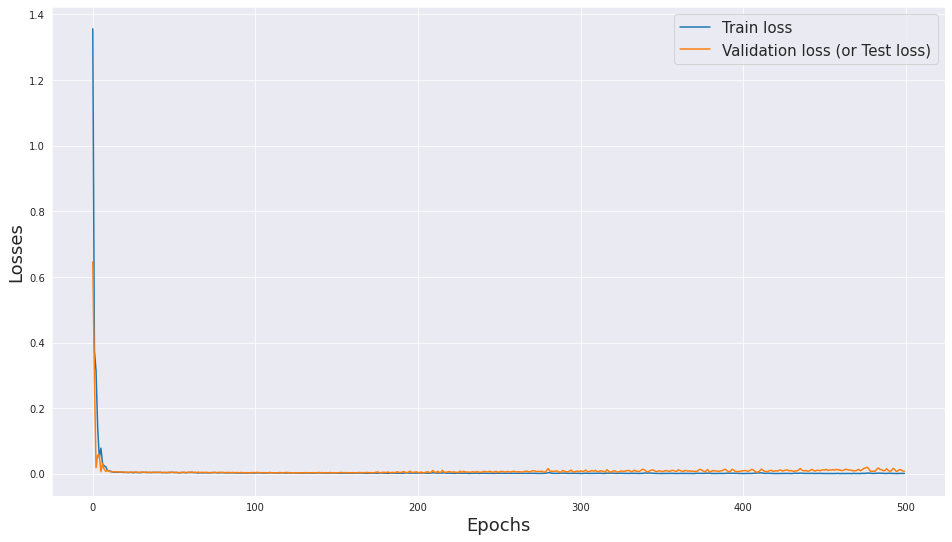

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(history.history["loss"], label = 'Train loss')
plt.plot(history.history["val_loss"], label = 'Validation loss (or Test loss)')
plt.xlabel('Epochs', fontsize = 18)
plt.xticks(x = 'Epochs', rotation = 0)
plt.ylabel('Losses', fontsize = 18)
plt.legend(fontsize=15)
plt.show()

## Scaling the test data

##### Note: The train data and test data are scaled after splitting the main data. This is because scaling invokes the calculation of statics. that is minimun, mean, maximum of a variable. When performing a prediction of the real data, one do not have the future data at the time of prediction. Hence, calculations of the scaling statistics has to be performed on the training data first and then must be applied to the test data. Otherwise, one use the future data/ information at the time of predicting which commonly biases prediction metries in a positive direction.

In [39]:
# Concatenate the training and testing data values as we will need these to our timesteps of 30 days to get the stock price for each day

inputs = dataset_original[len(dataset_original) - len(testing_data) - 30:].values
inputs.shape

(112, 3)

In [40]:
type(inputs)

numpy.ndarray

In [41]:
#inputs = inputs.reshape(1, n_input)
inputs = sc.transform(inputs)
inputs

array([[0.        , 0.23230925, 0.26276712],
       [0.10111928, 0.38667067, 0.32591933],
       [0.14487175, 0.34823928, 0.43567288],
       [0.12393004, 0.32492611, 0.40341049],
       [0.15100988, 0.36092504, 0.45092705],
       [0.16199058, 0.35090866, 0.43559655],
       [0.19616421, 0.40269928, 0.47266424],
       [0.14363998, 0.36355696, 0.40325794],
       [0.09266616, 0.32447707, 0.35627494],
       [0.12390878, 0.33633953, 0.37503767],
       [0.16275516, 0.36733652, 0.43681672],
       [0.34118478, 0.46851028, 0.58859591],
       [0.31164113, 0.47336254, 0.52712136],
       [0.34366985, 0.50242621, 0.57257888],
       [0.30824293, 0.49706248, 0.56960416],
       [0.38994965, 0.69722711, 0.65876454],
       [0.4038401 , 0.76858881, 0.67706962],
       [0.44765635, 0.87875618, 0.71505269],
       [0.47858033, 0.9115994 , 0.69453572],
       [0.4534971 , 0.93357781, 0.64312965],
       [0.39576914, 0.96683276, 0.63039196],
       [0.39237094, 0.90744558, 0.61002765],
       [0.

In [42]:
inputs.shape

(112, 3)

In [43]:
X_test = []
y_test = []

for i in range(30, len(inputs)):
    X_test.append(inputs[i-30:i, 0:])
    y_test.append(inputs[i, 0])

X_test, y_test

([array([[0.        , 0.23230925, 0.26276712],
         [0.10111928, 0.38667067, 0.32591933],
         [0.14487175, 0.34823928, 0.43567288],
         [0.12393004, 0.32492611, 0.40341049],
         [0.15100988, 0.36092504, 0.45092705],
         [0.16199058, 0.35090866, 0.43559655],
         [0.19616421, 0.40269928, 0.47266424],
         [0.14363998, 0.36355696, 0.40325794],
         [0.09266616, 0.32447707, 0.35627494],
         [0.12390878, 0.33633953, 0.37503767],
         [0.16275516, 0.36733652, 0.43681672],
         [0.34118478, 0.46851028, 0.58859591],
         [0.31164113, 0.47336254, 0.52712136],
         [0.34366985, 0.50242621, 0.57257888],
         [0.30824293, 0.49706248, 0.56960416],
         [0.38994965, 0.69722711, 0.65876454],
         [0.4038401 , 0.76858881, 0.67706962],
         [0.44765635, 0.87875618, 0.71505269],
         [0.47858033, 0.9115994 , 0.69453572],
         [0.4534971 , 0.93357781, 0.64312965],
         [0.39576914, 0.96683276, 0.63039196],
         [0.3

In [44]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test, y_test

(array([[[0.        , 0.23230925, 0.26276712],
         [0.10111928, 0.38667067, 0.32591933],
         [0.14487175, 0.34823928, 0.43567288],
         ...,
         [0.58405373, 0.97086172, 0.73473046],
         [0.56861287, 0.86728048, 0.70643426],
         [0.53471536, 0.76696718, 0.72870539]],
 
        [[0.10111928, 0.38667067, 0.32591933],
         [0.14487175, 0.34823928, 0.43567288],
         [0.12393004, 0.32492611, 0.40341049],
         ...,
         [0.56861287, 0.86728048, 0.70643426],
         [0.53471536, 0.76696718, 0.72870539],
         [0.59709456, 0.87127199, 0.77362876]],
 
        [[0.14487175, 0.34823928, 0.43567288],
         [0.12393004, 0.32492611, 0.40341049],
         [0.15100988, 0.36092504, 0.45092705],
         ...,
         [0.53471536, 0.76696718, 0.72870539],
         [0.59709456, 0.87127199, 0.77362876],
         [0.64063469, 0.85809974, 0.81481464]],
 
        ...,
 
        [[0.99156814, 1.79460898, 1.55137564],
         [0.94541564, 1.65843424, 1.47711

In [45]:
X_test.shape

(82, 30, 3)

In [46]:
n_input1 = X_test.shape[1] * X_test.shape[2]
X_test = X_test.reshape((X_test.shape[0], n_input))

In [47]:
X_train.shape, y_train.shape

((161, 90), (161,))

In [48]:
X_test.shape, y_test.shape

((82, 90), (82,))

## Make a prediction

In [49]:
# Predicting our dataset

y_train_predict = model.predict(X_train)
y_train_predict

array([[0.36454588],
       [0.38561738],
       [0.38762242],
       [0.39175525],
       [0.39589268],
       [0.38566214],
       [0.38020396],
       [0.3819398 ],
       [0.38606513],
       [0.37170696],
       [0.3813455 ],
       [0.36516008],
       [0.34699798],
       [0.32768938],
       [0.31577078],
       [0.30905235],
       [0.3168983 ],
       [0.32834297],
       [0.31373265],
       [0.32750574],
       [0.35330132],
       [0.35872388],
       [0.3636833 ],
       [0.38661122],
       [0.40288594],
       [0.4268183 ],
       [0.42815787],
       [0.41772464],
       [0.42219067],
       [0.43673488],
       [0.44854277],
       [0.44538742],
       [0.4619578 ],
       [0.46504432],
       [0.45239478],
       [0.44807065],
       [0.4640594 ],
       [0.47645032],
       [0.49271163],
       [0.5029502 ],
       [0.50656044],
       [0.51947033],
       [0.52227867],
       [0.5250188 ],
       [0.54180723],
       [0.5534158 ],
       [0.5584883 ],
       [0.562

In [50]:
y_test_predict = model.predict(X_test)
y_test_predict

array([[0.49544057],
       [0.4923963 ],
       [0.47699046],
       [0.4602116 ],
       [0.42343208],
       [0.4395065 ],
       [0.45774427],
       [0.47751972],
       [0.4440406 ],
       [0.42003137],
       [0.46953124],
       [0.46370202],
       [0.48360568],
       [0.5294032 ],
       [0.5778408 ],
       [0.60688716],
       [0.61713046],
       [0.65302926],
       [0.6608256 ],
       [0.65367794],
       [0.65500426],
       [0.65152407],
       [0.64858603],
       [0.6596122 ],
       [0.65669745],
       [0.6419667 ],
       [0.65504926],
       [0.6449935 ],
       [0.63539505],
       [0.60902023],
       [0.65099776],
       [0.679805  ],
       [0.69897956],
       [0.6923454 ],
       [0.69688106],
       [0.6703876 ],
       [0.66926014],
       [0.6870308 ],
       [0.7329526 ],
       [0.68495697],
       [0.6655531 ],
       [0.62533146],
       [0.6560072 ],
       [0.700793  ],
       [0.7231761 ],
       [0.7333691 ],
       [0.74806684],
       [0.749

In [51]:
y_train_predict.shape

(161, 1)

In [52]:
y_test_predict.shape

(82, 1)

In [53]:
type(y_test_predict)

numpy.ndarray

In [54]:
y_train_predict, y_train

(array([[0.36454588],
        [0.38561738],
        [0.38762242],
        [0.39175525],
        [0.39589268],
        [0.38566214],
        [0.38020396],
        [0.3819398 ],
        [0.38606513],
        [0.37170696],
        [0.3813455 ],
        [0.36516008],
        [0.34699798],
        [0.32768938],
        [0.31577078],
        [0.30905235],
        [0.3168983 ],
        [0.32834297],
        [0.31373265],
        [0.32750574],
        [0.35330132],
        [0.35872388],
        [0.3636833 ],
        [0.38661122],
        [0.40288594],
        [0.4268183 ],
        [0.42815787],
        [0.41772464],
        [0.42219067],
        [0.43673488],
        [0.44854277],
        [0.44538742],
        [0.4619578 ],
        [0.46504432],
        [0.45239478],
        [0.44807065],
        [0.4640594 ],
        [0.47645032],
        [0.49271163],
        [0.5029502 ],
        [0.50656044],
        [0.51947033],
        [0.52227867],
        [0.5250188 ],
        [0.54180723],
        [0

In [55]:
y_test_predict, y_test

(array([[0.49544057],
        [0.4923963 ],
        [0.47699046],
        [0.4602116 ],
        [0.42343208],
        [0.4395065 ],
        [0.45774427],
        [0.47751972],
        [0.4440406 ],
        [0.42003137],
        [0.46953124],
        [0.46370202],
        [0.48360568],
        [0.5294032 ],
        [0.5778408 ],
        [0.60688716],
        [0.61713046],
        [0.65302926],
        [0.6608256 ],
        [0.65367794],
        [0.65500426],
        [0.65152407],
        [0.64858603],
        [0.6596122 ],
        [0.65669745],
        [0.6419667 ],
        [0.65504926],
        [0.6449935 ],
        [0.63539505],
        [0.60902023],
        [0.65099776],
        [0.679805  ],
        [0.69897956],
        [0.6923454 ],
        [0.69688106],
        [0.6703876 ],
        [0.66926014],
        [0.6870308 ],
        [0.7329526 ],
        [0.68495697],
        [0.6655531 ],
        [0.62533146],
        [0.6560072 ],
        [0.700793  ],
        [0.7231761 ],
        [0

In [56]:
sc.scale_               # Here, inverse transform is not applicable as only one column of y_test is to be scaled. Inverse transform is used to scale a complete dataset

array([0.00212391, 0.00124737, 0.03074479])

In [57]:
scale = 1/0.00212391
scale

470.82974325654095

In [58]:
y_train_predict = y_train_predict*scale
y_train = y_train*scale

In [59]:
y_train

array([175.73991081, 174.06986762, 175.25993055, 173.86991653,
       175.94987165, 177.26993941, 170.19987425, 183.62992189,
       159.6399425 , 185.76993557, 186.45987666, 164.22990624,
       166.11992004, 140.12994155, 126.96991332, 137.91998161,
       150.6299368 , 142.39996005, 144.95989542, 142.22991619,
       167.6599584 , 157.51994834, 165.12993025, 185.43997966,
       195.02994115, 198.31985666, 192.32986913, 188.10990033,
       183.83988273, 202.7398986 , 195.62991647, 218.62990607,
       219.62990562, 198.77993946, 203.62991285, 209.42995906,
       219.73989092, 234.82984992, 233.71986507, 237.90992665,
       245.14991362, 247.62989296, 242.19984171, 236.80995156,
       238.62989703, 258.6799368 , 275.96984597, 270.25988762,
       254.98987499, 242.87989511, 246.62989341, 239.88990623,
       253.53992447, 259.04993175, 250.22986737, 246.18995221,
       222.2899386 , 249.7298676 , 270.62988257, 276.37987997,
       282.48986256, 283.56981813, 291.92992177, 286.83

In [60]:
y_test_predict = y_test_predict*scale
y_test = y_test*scale

In [61]:
y_test

array([281.12987782, 301.62986856, 304.93992565, 325.44980408,
       320.41989913, 351.84981656, 319.78989453, 277.14989915,
       291.88988272, 305.20982299, 329.10983661, 332.78988865,
       354.61983484, 347.52987223, 385.58979155, 363.62984054,
       343.62984957, 364.05989405, 369.32978913, 378.62983376,
       386.32978145, 380.40986225, 359.26985715, 369.90986699,
       388.86981936, 405.13983154, 384.65986033, 369.48982324,
       333.11984456, 392.62982743, 396.56976705, 393.47980263,
       383.6298315 , 368.63984804, 395.62982607, 406.90985027,
       374.84980617, 376.25983971, 303.96983332, 340.50985587,
       362.79988486, 395.46979196, 431.77983415, 439.75981101,
       444.42985284, 453.5598536 , 456.87979839, 493.56972321,
       436.4198467 , 466.85977435, 445.1298037 , 460.53983092,
       458.6297976 , 528.65979524, 499.33974014, 509.55982829,
       442.81974615, 456.88980815, 468.62979308, 448.62980212,
       441.599776  , 440.67985454, 434.62980845, 430.33

In [62]:
y_train_predict

array([[171.63904 ],
       [181.56013 ],
       [182.50417 ],
       [184.45003 ],
       [186.39806 ],
       [181.5812  ],
       [179.01134 ],
       [179.82861 ],
       [181.77095 ],
       [175.0107  ],
       [179.54881 ],
       [171.92822 ],
       [163.37697 ],
       [154.2859  ],
       [148.67427 ],
       [145.51103 ],
       [149.20514 ],
       [154.59364 ],
       [147.71466 ],
       [154.19945 ],
       [166.34477 ],
       [168.89787 ],
       [171.23293 ],
       [182.02806 ],
       [189.69069 ],
       [200.95876 ],
       [201.58946 ],
       [196.67719 ],
       [198.77992 ],
       [205.62778 ],
       [211.18727 ],
       [209.70164 ],
       [217.50348 ],
       [218.9567  ],
       [213.00092 ],
       [210.96498 ],
       [218.49298 ],
       [224.32698 ],
       [231.98329 ],
       [236.80391 ],
       [238.50372 ],
       [244.58208 ],
       [245.90433 ],
       [247.19447 ],
       [255.09895 ],
       [260.5646  ],
       [262.9529  ],
       [264.7

In [63]:
y_test_predict

array([[233.26816],
       [231.83482],
       [224.5813 ],
       [216.6813 ],
       [199.36443],
       [206.93274],
       [215.51962],
       [224.83049],
       [209.06752],
       [197.76326],
       [221.06927],
       [218.3247 ],
       [227.69594],
       [249.25877],
       [272.06464],
       [285.74054],
       [290.5634 ],
       [307.4656 ],
       [311.13635],
       [307.77103],
       [308.39548],
       [306.7569 ],
       [305.3736 ],
       [310.56503],
       [309.1927 ],
       [302.25702],
       [308.4167 ],
       [303.68213],
       [299.1629 ],
       [286.74484],
       [306.5091 ],
       [320.07242],
       [329.10037],
       [325.9768 ],
       [328.11234],
       [315.63843],
       [315.10757],
       [323.47452],
       [345.0959 ],
       [322.4981 ],
       [313.36218],
       [294.42465],
       [308.86768],
       [329.9542 ],
       [340.49283],
       [345.292  ],
       [352.21213],
       [352.68594],
       [376.21445],
       [362.36136],


## Visualizing Stock prediction prices with actual Stock prices

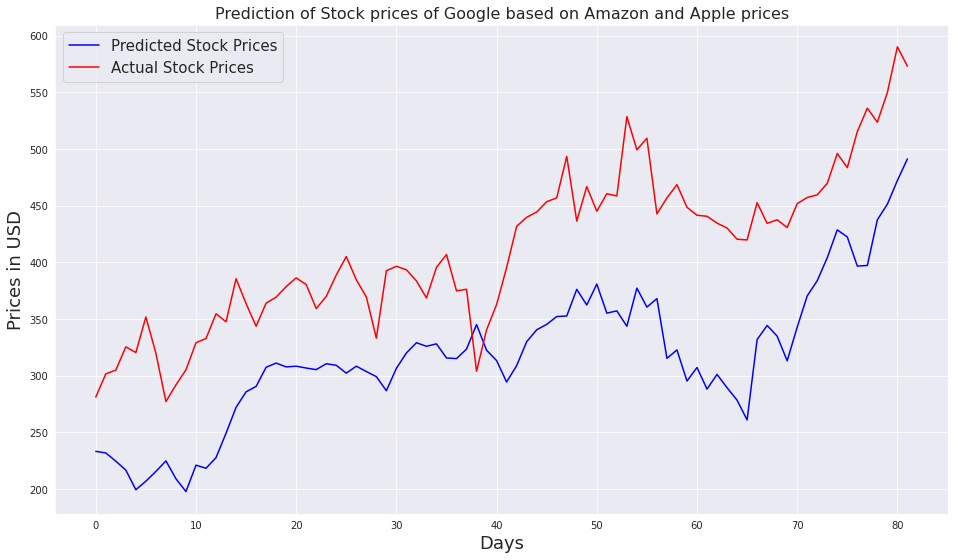

In [64]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(y_test_predict, color = 'blue', label = 'Predicted Stock Prices')
plt.plot(y_test, color = 'red', label = 'Actual Stock Prices')
plt.title("Prediction of Stock prices of Google based on Amazon and Apple prices", fontsize = 16)
plt.xlabel('Days', fontsize = 18)
plt.xticks(x = 'Days', rotation = 0)
#plt.margins(0.2)
plt.ylabel('Prices in USD', fontsize = 18)
plt.legend(fontsize=15)
plt.show()

## Calculating RMSE performance metrics

In [65]:
import math
from sklearn.metrics import mean_squared_error

In [66]:
math.sqrt(mean_squared_error(y_train, y_train_predict))

21.192968435538514

In [67]:
math.sqrt(mean_squared_error(y_test, y_test_predict))

100.56090563788462